In [1]:
import numpy as np
import json, random
import matplotlib.pyplot as plt
from pathlib import Path
import importlib

SEED = 42
random.seed(SEED); np.random.seed(SEED)

try:
    import torch
    torch.manual_seed(SEED)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(SEED)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
except Exception:
    torch = None

## Data Inspection

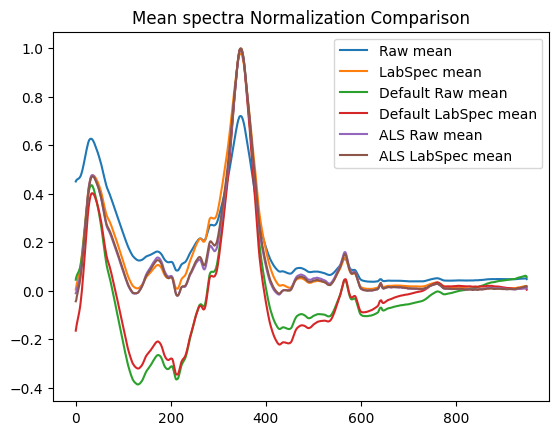

In [16]:
from pyspectral.data.io import SpectraPair, read_pairs
from pyspectral.data.preprocessing import PeakNormConfig, GlobalPeakNorm, ALS, PreConfig
from pyspectral.config import DATA_DIR

DATA = DATA_DIR
ANN  = DATA / "annotations_S80.csv"
peak_cfg = PeakNormConfig(mode=GlobalPeakNorm())
pre_none = PreConfig(baseline=None)
pre_poly = PreConfig.make_poly(7, 3)
pre_ALS = PreConfig.make_als()

rows = read_pairs( ANN, DATA)
pairs_none, arts_none = SpectraPair.from_annotations(rows, peak_cfg=peak_cfg, pre_config=pre_none)
pairs_def, arts_def = SpectraPair.from_annotations(rows, pre_config=pre_poly)
pairs_als, arts_als = SpectraPair.from_annotations(rows, pre_config=pre_ALS) 

X_none = pairs_none.X_raw.astype(np.float32)   
Y_none  = pairs_none.Y_proc.astype(np.float32)  
X_def = pairs_def.X_raw.astype(np.float32)   # (N,C)
Y_def = pairs_def.Y_proc.astype(np.float32)  # (N,C)
X_als = pairs_als.X_raw.astype(np.float32)   
Y_als  = pairs_als.Y_proc.astype(np.float32)  

N, C = X.shape
H, W = 8, 8
assert N == H*W, f"Expected {H}x{W} grid -> N={H*W}, got N={N}"

plt.plot(X_none.mean(0), label="Raw mean"); plt.plot(Y_none.mean(0), label="LabSpec mean");
plt.plot(X_def.mean(0), label="Default Raw mean"); plt.plot(Y_def.mean(0), label="Default LabSpec mean");
plt.plot(X_als.mean(0), label="ALS Raw mean"); plt.plot(Y_als.mean(0), label="ALS LabSpec mean");
plt.legend(); plt.title("Mean spectra Normalization Comparison"); plt.show()

## Baselines

### Classical Baseline

In [23]:
from sklearn.model_selection import KFold
from sklearn.metrics import root_mean_squared_error as RMSE
import pyspectral.modeling.predict as predict

cv = KFold(n_splits=4, shuffle=True, random_state=42)

def classic(pairs, Y, lbl):
    x, y = pairs.X_raw, pairs.Y_proc
    yhat_diag  = predict.diagonal_affine_predict(x, y, cv)                   
    yhat_pcr   = predict.pcr_predict(x, y, cv)
    yhat_enet  = predict.multitask_elasticnet_predict(x, y, cv)
    print(f"{lbl} Diagonal affine (OOF) RMSE: {RMSE(Y, yhat_diag):.4f}")
    print(f"{lbl} PCR (OOF) RMSE:             {RMSE(Y, yhat_pcr):.4f}")
    print(f"{lbl} ElasticNet (OOF) RMSE:      {RMSE(Y, yhat_enet):.4f}")
    print("-"*12)
    return yhat_diag, yhat_pcr, yhat_enet

yhat_d_def, yhat_p_def, yhat_e_def = classic(pairs_def, pairs_none.Y_proc, "default")
yhat_d_n, yhat_p_n, yhat_e_n = classic(pairs_new_norm, pairs_none.Y_proc, "new norm")
yhat_d_a, yhat_p_a, yhat_e_a = classic(pairs_als, pairs_none.Y_proc,"ALS")



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:31<00:00,  7.84s/it]


default Diagonal affine (OOF) RMSE: 0.9007
default PCR (OOF) RMSE:             0.7950
default ElasticNet (OOF) RMSE:      0.1390
------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [01:26<00:00, 21.61s/it]


new norm Diagonal affine (OOF) RMSE: 0.4824
new norm PCR (OOF) RMSE:             0.7148
new norm ElasticNet (OOF) RMSE:      0.0076
------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:38<00:00,  9.53s/it]

ALS Diagonal affine (OOF) RMSE: 1.0229
ALS PCR (OOF) RMSE:             0.6774
ALS ElasticNet (OOF) RMSE:      0.0239
------------


### Train a low-rank linear neural network mapper & cache OOF preds

In [27]:
import pyspectral.modeling.train as tr
from pyspectral.config import SpecModelType
from functools import partial
importlib.reload(tr)

train_nn = partial(tr.cv_train_model, 
    n_splits=4,
    epochs=10, 
    lr=2e-4,
    model_type=SpecModelType.LRSM, 
    rank=12,
    verbose=True)

oof_stats_def = train_nn(
    spectral_pairs=pairs_def,
    arts=arts_def,
)
oof_stats_nnorm = train_nn(
    spectral_pairs=pairs_new_norm,
    arts=arts_def,
)
oof_stats_als = train_nn(
    spectral_pairs=pairs_als,
    arts=arts_als,
)

print(f"{oof_stats_def=}") 
print(f"{oof_stats_nnorm=}") 
print(f"{oof_stats_als=}") 
LR_pred_def = oof_stats_def.pred_orig  # (N,C) in original units
LR_pred_nnorm = oof_stats_nnorm.pred_orig  
LR_pred_als = oof_stats_als.pred_orig  


1it [02:17, 137.54s/it]

Fold 1/4 |train loss=0.19 | test loss=0.172 | best test loss=0.164 | frac improved vs identity=0.000


2it [04:30, 134.85s/it]

Fold 2/4 |train loss=0.213 | test loss=0.227 | best test loss=0.194 | frac improved vs identity=0.000


3it [06:40, 132.58s/it]

Fold 3/4 |train loss=0.189 | test loss=0.294 | best test loss=0.267 | frac improved vs identity=0.000


4it [08:51, 132.83s/it]


Fold 4/4 |train loss=0.19 | test loss=0.219 | best test loss=0.2 | frac improved vs identity=0.000


1it [02:07, 127.43s/it]

Fold 1/4 |train loss=0.863 | test loss=0.576 | best test loss=0.456 | frac improved vs identity=0.000


2it [04:15, 127.91s/it]

Fold 2/4 |train loss=0.905 | test loss=1.13 | best test loss=0.778 | frac improved vs identity=0.000


3it [06:25, 128.93s/it]

Fold 3/4 |train loss=0.862 | test loss=1.13 | best test loss=0.851 | frac improved vs identity=0.000


4it [08:34, 128.74s/it]


Fold 4/4 |train loss=0.899 | test loss=1.06 | best test loss=0.689 | frac improved vs identity=0.000


1it [02:07, 127.76s/it]

Fold 1/4 |train loss=0.0479 | test loss=0.0403 | best test loss=0.0389 | frac improved vs identity=0.000


2it [04:18, 129.70s/it]

Fold 2/4 |train loss=0.0494 | test loss=0.0472 | best test loss=0.0439 | frac improved vs identity=0.000


3it [06:26, 129.00s/it]

Fold 3/4 |train loss=0.0464 | test loss=0.0659 | best test loss=0.0556 | frac improved vs identity=0.000


4it [08:35, 128.94s/it]

Fold 4/4 |train loss=0.0477 | test loss=0.0498 | best test loss=0.0448 | frac improved vs identity=0.000
oof_stats_def=<pyspectral.modeling.train.OOFStats object at 0x0000016DF63FEE40>
oof_stats_nnorm=<pyspectral.modeling.train.OOFStats object at 0x0000016DEEEF0690>
oof_stats_als=<pyspectral.modeling.train.OOFStats object at 0x0000016DF1F72D50>


## Summarize models

In [29]:
import polars as pl
rank=12
df = pl.DataFrame(
    {
        "model": ["def diag_affine", "def PCR", "def ElasticNet", f"def LowRank_r{rank}", 
        "nnorm diag_affine", "nnorm PCR", "nnorm ElasticNet", f"nnorm LowRank_r{rank}",
        "ALS diag_affine", "ALS PCR", "ALS ElasticNet", f"ALS LowRank_r{rank}"
        ],
        "oof_rmse": [
            RMSE(Y, yhat_d_def), RMSE(Y, yhat_p_def), RMSE(Y, yhat_e_def), RMSE(Y, LR_pred_def),
            RMSE(Y, yhat_d_n), RMSE(Y, yhat_p_n), RMSE(Y, yhat_e_n), RMSE(Y, LR_pred_nnorm),
            RMSE(Y, yhat_d_a), RMSE(Y, yhat_p_a), RMSE(Y, yhat_e_a), RMSE(Y, LR_pred_als)
            ]
    }
).sort("oof_rmse") # sort table in terms of rmse
df

model,oof_rmse
str,f64
"""def LowRank_r12""",0.004577
"""def ElasticNet""",0.007209
"""ALS LowRank_r12""",0.122246
"""ALS ElasticNet""",0.122504
"""nnorm LowRank_r12""",0.139074
…,…
"""ALS PCR""",0.675806
"""nnorm PCR""",0.715878
"""def PCR""",0.789847


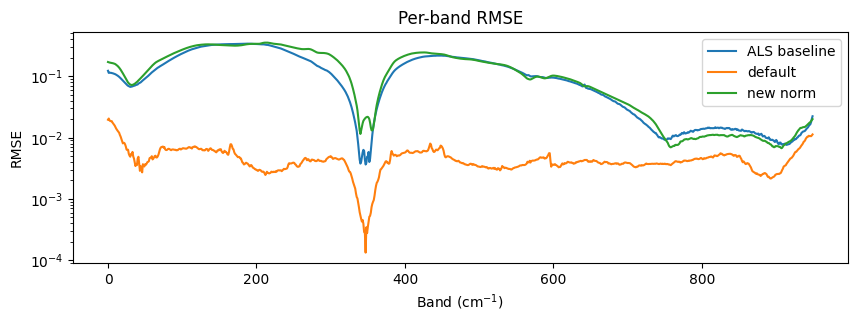

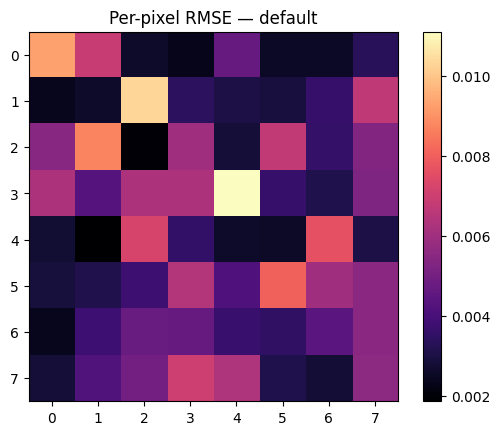

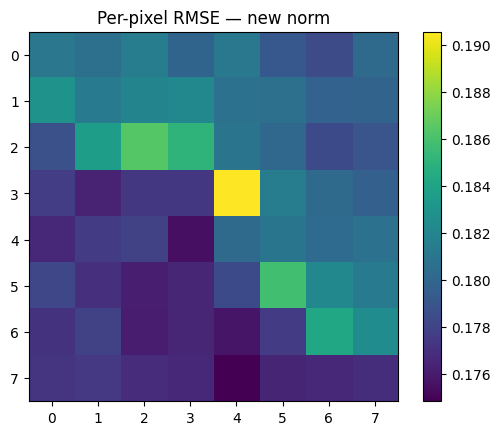

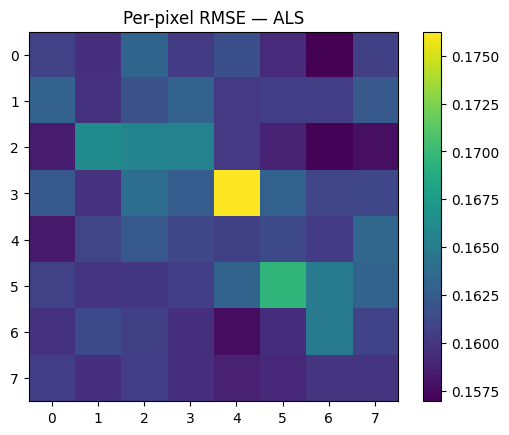

In [30]:
from pyspectral.plots import rmse_per_pixel
x_label = r"Band ($\text{cm}^{-1}$)"
per_band_rmse_def = np.sqrt(((Y - LR_pred_def)**2).mean(axis=0))
per_band_rmse_nnorm = np.sqrt(((Y - LR_pred_nnorm)**2).mean(axis=0))
per_band_rmse_als = np.sqrt(((Y - LR_pred_als)**2).mean(axis=0))
plt.figure(figsize=(10,3));plt.plot(per_band_rmse_als, label="ALS baseline"); plt.plot(per_band_rmse_def , label="default"); plt.plot(per_band_rmse_nnorm, label="new norm")
plt.title("Per-band RMSE"); plt.xlabel(x_label); plt.ylabel("RMSE"); plt.yscale("log"); plt.legend(); plt.show()

rmse_px_def = rmse_per_pixel(Y, LR_pred_def).reshape(H,W)
rmse_px_nnorm = rmse_per_pixel(Y, LR_pred_nnorm).reshape(H,W)
rmse_px_als = rmse_per_pixel(Y, LR_pred_als).reshape(H,W)
plt.imshow(rmse_px_def, cmap="magma"); plt.colorbar(); plt.title("Per-pixel RMSE — default"); plt.show()
plt.imshow(rmse_px_nnorm); plt.colorbar(); plt.title("Per-pixel RMSE — new norm"); plt.show()
plt.imshow(rmse_px_als); plt.colorbar(); plt.title("Per-pixel RMSE — ALS"); plt.show()

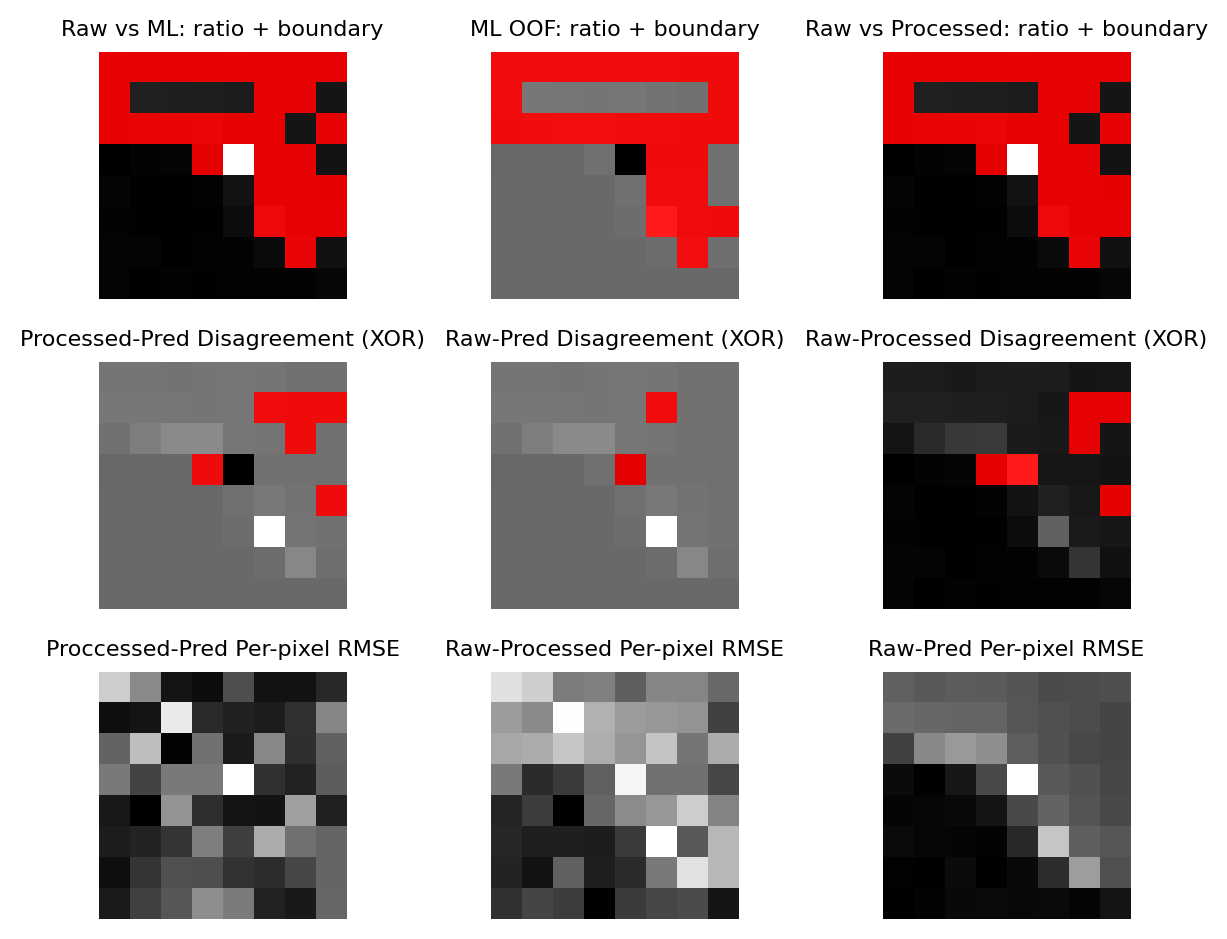

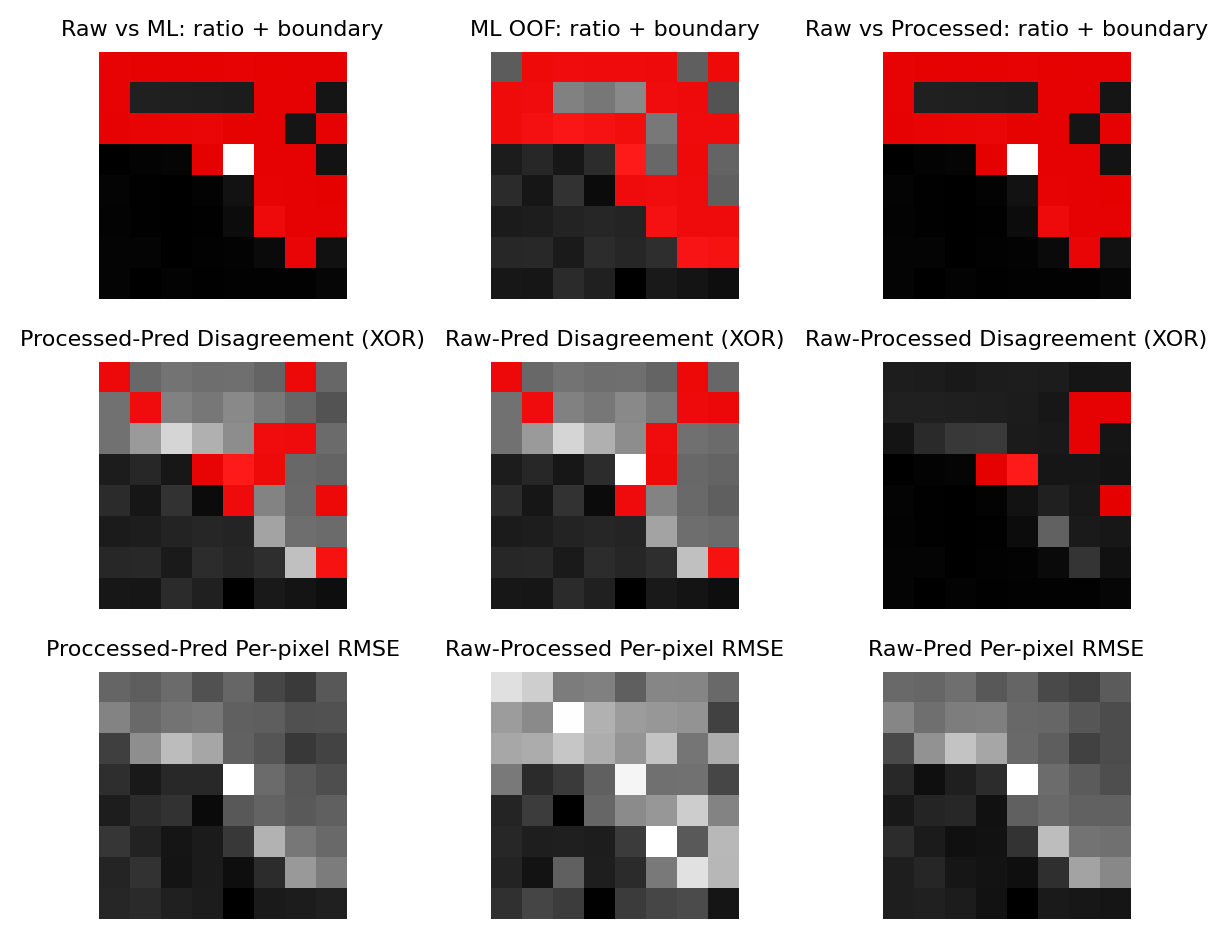

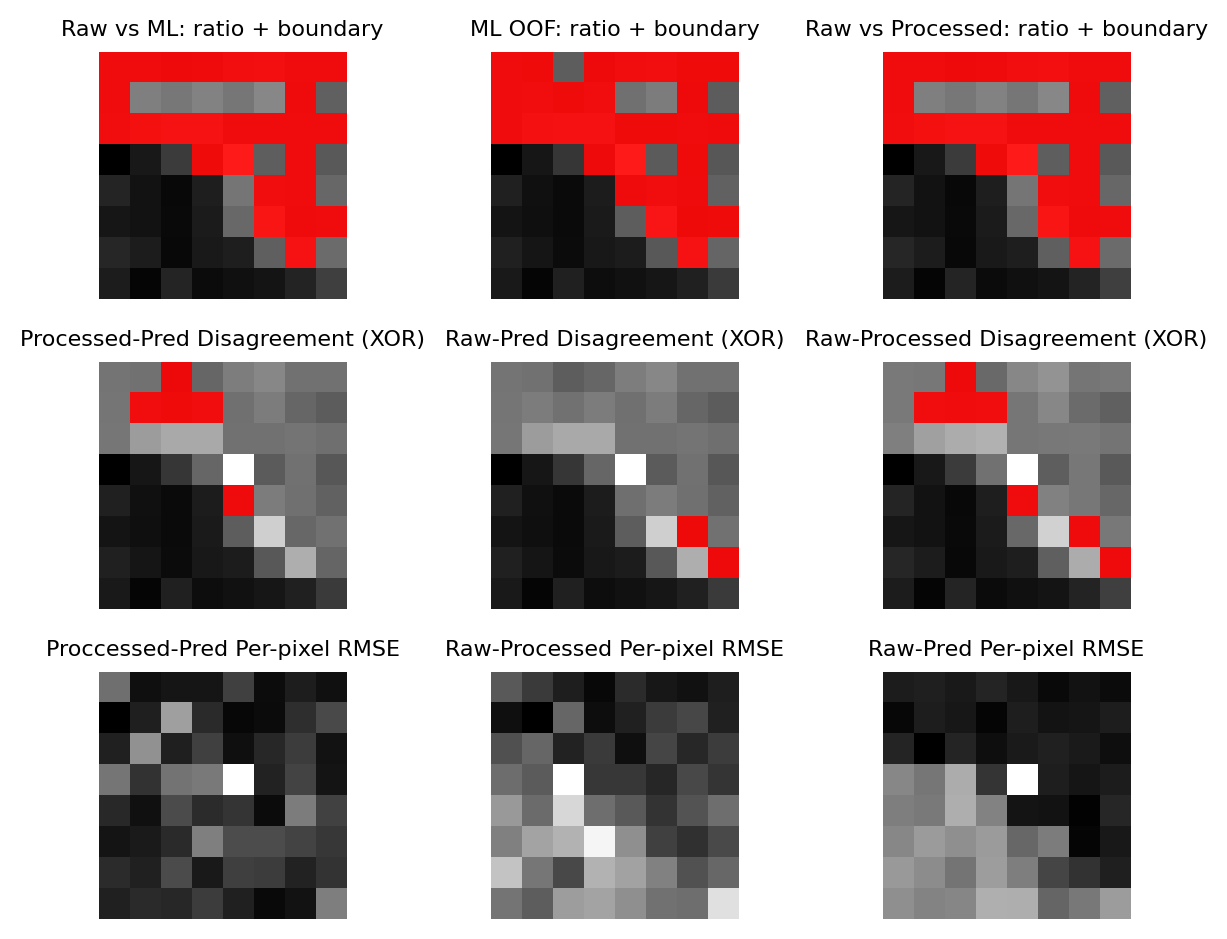

In [36]:
import pyspectral.plots as plot
import importlib
importlib.reload(predict); importlib.reload(plot);
scene_idx = 0  # pick a scene 
pdata_def = predict.predict_cube(scene_idx, oof_stats_def, base_dir=DATA, csv_path=ANN)
metrics_def = plot.compare_boundaries(pdata_def)

pdata_nnorm = predict.predict_cube(scene_idx, oof_stats_nnorm, base_dir=DATA, csv_path=ANN)
metrics_nnorm = plot.compare_boundaries(pdata_nnorm)

pdata_als = predict.predict_cube(scene_idx, oof_stats_als, base_dir=DATA, csv_path=ANN)
metrics_als = plot.compare_boundaries(pdata_als)

